In [1]:
import numpy as np
import pandas as pd
import scipy.sparse
import pickle

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import plotly.graph_objects as go
import pyLDAvis
import pyLDAvis.sklearn
import seaborn as sns
sns.set_style('white')

import re
import en_core_web_sm
import spacy
import nltk

import string
from nltk.corpus import stopwords

import psycopg2 as pg2

import ipywidgets as widgets
from ipywidgets import interact, interactive,fixed

import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import nmf
from sklearn.feature_extraction.text import CountVectorizer


from wordcloud import WordCloud, STOPWORDS
from subprocess import check_output
import matplotlib as mpl

%matplotlib inline

C:\Users\16142\Anaconda3\lib\site-packages\past\types\oldstr.py:5: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working

C:\Users\16142\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning:

`formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly

C:\Users\16142\Anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working



## music lyric look up class

In [2]:
# class that puts all the SQL query actions under the hood.

class Query:

    def total(self,artist):
        conn = pg2.connect(database='Music',user='postgres',password='obscura88')
        cur=conn.cursor()
        cur.execute("SELECT artist, SUM(lyrics_word_length), SUM(cleaned_lyrics_word_length) FROM music_lyrics WHERE artist = (%s)  GROUP BY artist", [artist])    
        result=cur.fetchone()
        conn.close()   
        return print(f"{result[0]} has {result[1]} total words in their lyrics and {result[2]} excluding stopwords")
        
    def song_count(self,artist):
        conn = pg2.connect(database='Music',user='postgres',password='obscura88')
        cur=conn.cursor()
        cur.execute("SELECT title AS Bon_Iver, lyrics_word_length, cleaned_lyrics_word_length FROM music_lyrics WHERE artist = (%s)",[artist])
        song=cur.fetchall()
        conn.close() 
        return song
    
    def album_count(self,artist):
        conn = pg2.connect(database='Music',user='postgres',password='obscura88')
        cur=conn.cursor()
        cur.execute("SELECT album, SUM(lyrics_word_length), SUM(cleaned_lyrics_word_length) FROM music_lyrics WHERE artist = (%s) GROUP BY album",[artist])
        album=cur.fetchall()
        conn.close()
        return album  
        
    def album_avg(self,artist):
        conn = pg2.connect(database='Music',user='postgres',password='obscura88')
        cur=conn.cursor()
        cur.execute("SELECT artist,ROUND(AVG(original),0) AS average_word_count,ROUND(AVG(cleaned),0) AS cleaned_lyrics_word_length FROM (SELECT artist, album, SUM(lyrics_word_length) AS original, SUM(cleaned_lyrics_word_length) AS cleaned FROM music_lyrics WHERE artist = (%s) GROUP BY album, artist) AS T GROUP BY artist",[artist])
        albumavg=cur.fetchone()
        conn.close
        print(f'{albumavg[0]} averages {albumavg[1]} words an album {albumavg[2]} of which are non stopwords')
        print('\n')
        return
        
    def song_avg(self,artist):
        conn = pg2.connect(database='Music',user='postgres',password='obscura88')
        cur=conn.cursor()
        cur.execute("SELECT artist, ROUND(AVG(lyrics_word_length),0) AS average_word_count, ROUND(AVG(cleaned_lyrics_word_length),0) AS average_cleaned_word_count FROM music_lyrics GROUP BY artist ORDER BY average_word_count DESC")
        song_avg=cur.fetchall()
        for j in song_avg:
            if j[0] == artist:
                print(f'{j[0]} has an average of {j[1]} words per song {j[2]} of which are non stopwords')
        print('\n')
        return
    
    def similar(self,artist):
        conn = pg2.connect(database='Music',user='postgres',password='obscura88')
        cur=conn.cursor()
        cur.execute("SELECT artist, rnk FROM verbosity WHERE rnk BETWEEN( SELECT rnk from verbosity WHERE artist = (%s))-3 AND( SELECT rnk from verbosity WHERE artist = (%s))+3",(artist,artist))
        similar=cur.fetchall()
        print(f'Some artists similar to {artist} in terms of verbosity in your library:')
        print('-------------------------------------------------------------------')
        for j in similar:
            if j[0] != artist:
                print(f'{j[0]}')
        print('\n')
        return

    def fluff(self,artist):
        conn = pg2.connect(database='Music',user='postgres',password='obscura88')
        cur=conn.cursor()
        cur.execute("SELECT artist, fluff FROM fluff WHERE rnk BETWEEN(SELECT rnk from fluff WHERE artist = (%s))-3 AND(SELECT rnk from fluff WHERE artist = (%s))+3",(artist,artist))
        fluff=cur.fetchall()
        for j in fluff:
            if j[0] == artist:
                print(f'Some artists similar to {artist} in terms of fluff in your library:')
                print('(fluff is the ratio of non stopwords divided by all words)')
        print('-------------------------------------------------------------------')
        for j in fluff:
            if j[0] != artist:
                print(f'{j[0]}')
        print('\n')
        return

    
# calls to a set queries from the Query class that and formats it 
def lookup(artist):
    print(f'\nSome info on {artist}!\n')
    print('###########################################################################\n')
    Query().album_avg(artist)
    Query().song_avg(artist)
    Query().similar(artist)
    Query().fluff(artist)

# pulls the list of artists in the SQL library 
def info():

    artists=[]
    conn = pg2.connect(database='Music',user='postgres',password='obscura88')
    cur=conn.cursor()
    cur.execute("SELECT DISTINCT artist FROM music_lyrics ORDER BY artist ASC")
    ar=cur.fetchall()
    for j in ar:
        artists.append(j[0])

    w=interact(lookup, artist=artists)
    display(w)
    
def album_bar(artist):
    
    q=Query().album_count(artist)
    title=[]
    count=[]
    clean=[]
    for j in q:
        title.append(j[0])
        count.append(j[1])
        clean.append(j[2])

    font = {'weight' : 'normal',
            'size'   : 18}
    matplotlib.rc('font', **font)
    x=np.arange(len(title))
    width=.3

    fig,ax = plt.subplots(figsize=(13,10))
    rects1=ax.bar(x-width/2,count,width,label='Word count')
    rects2=ax.bar(x+width/2,clean,width,label='cleaned word count')

    ax.set_xlabel('Album Title',fontsize=16)
    ax.set_ylabel('Word Count',fontsize=16)
    ax.set_title(f'Word count by album for {artist}',fontsize=22)

    ax.set_ylim(0,(max(count)+max(count)*.4))
    ax.set_xticks(x)
    plt.xticks(rotation=90)
    ax.set_xticklabels(title)
    ax.legend(loc='upper right', facecolor='white',framealpha=1)

    ax.yaxis.grid()
    ax.set_axisbelow(True)
    fig.tight_layout()

def info_album():
    
    artists=[]
    conn = pg2.connect(database='Music',user='postgres',password='obscura88')
    cur=conn.cursor()
    cur.execute("SELECT DISTINCT artist FROM music_lyrics ORDER BY artist ASC")
    ar=cur.fetchall()
    for j in ar:
        artists.append(j[0])

    w=interact(album_bar, artist=artists)
    display(w)

    
def song_bar(artist):
    
    q=Query().song_count(artist)
    title=[]
    count=[]
    clean=[]
    for j in q:
        title.append(j[0])
        count.append(j[1])
        clean.append(j[2])

    font = {'weight' : 'normal',
            'size'   : 18}
    matplotlib.rc('font', **font)
    x=np.arange(len(title))
    width=.3

    fig,ax = plt.subplots(figsize=(13,10))
    rects1=ax.bar(x-width/2,count,width,label='Word count')
    rects2=ax.bar(x+width/2,clean,width,label='cleaned word count')

    ax.set_xlabel('Song Title',fontsize=16)
    ax.set_ylabel('Word Count',fontsize=16)
    ax.set_title(f'Word count by song for {artist}',fontsize=22)

    ax.set_ylim(0,(max(count)+max(count)*.4))
    ax.set_xticks(x)
    plt.xticks(rotation=90)
    ax.set_xticklabels(title)
    ax.legend(loc='upper right', facecolor='white',framealpha=1)

    ax.yaxis.grid()
    ax.set_axisbelow(True)
    fig.tight_layout()

def info_song():
    
    artists=[]
    conn = pg2.connect(database='Music',user='postgres',password='obscura88')
    cur=conn.cursor()
    cur.execute("SELECT DISTINCT artist FROM music_lyrics ORDER BY artist ASC")
    ar=cur.fetchall()
    for j in ar:
        artists.append(j[0])

    w=interact(song_bar, artist=artists)
    display(w)


## clean and process

clean the data, input the csv into a SQL database and build a class that outputs info based on artist via SQL queries.

First issue, punctuation. Need to remove punctuation, specifically ' and " from the csv. these characters are used as quote and escape characters by PostgreSQL. Need to remove them from the album, artist, title, and lyrics columns.


In [3]:
songlyrics = pd.read_csv('song_lyrics.csv',index_col='song_id')

In [4]:
def no_punc(mess):

    nopunc = [c for c in mess if c not in string.punctuation]
    
    nopunc=''.join(nopunc)
    
    return nopunc  

In [5]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

def lemmatizer(text,i=[0]):
    sent = []
    doc = nlp(text)
    for word in doc:
        
        sent.append(word.lemma_)
    return " ".join(sent)

In [6]:
nlp = en_core_web_sm.load()

In [7]:
songlyrics['artist']=songlyrics['artist'].apply(no_punc)
songlyrics['album']=songlyrics['album'].apply(no_punc)
songlyrics['title']=songlyrics['title'].apply(no_punc)

songlyrics['cleaned_lyrics']=songlyrics['lyrics'].apply(clean_text)
songlyrics['cleaned_lyrics']=songlyrics['cleaned_lyrics'].apply(lemmatizer)
songlyrics['cleaned_lyrics']=songlyrics['cleaned_lyrics'].str.replace('-PRON-','')

length=[]
for i,j in songlyrics.iterrows():
    length.append((len(j[7].split())))
songlyrics['lyrics_word_length']=length

length=[]
for i,j in songlyrics.iterrows():
    length.append((len(j[8].split())))
songlyrics['cleaned_lyrics_word_length']=length

songlyrics['lyrics']=songlyrics['lyrics'].apply(no_punc)

In [8]:
artists={}
art_id=[]
n=0

for i,j in songlyrics.iterrows():
    if j[0] not in artists.keys():
        artists[j[0]]=int(n)
        n+=1
        
for i,j in songlyrics.iterrows():
    if j[0] in artists.keys():
        art_id.append(artists[j[0]])
songlyrics['artist_id']=art_id

In [9]:
# save cleaned lyrics
#duration column is being difficult, just drop it.
songlyrics.drop('duration',inplace=True,axis=1)
songlyrics.to_csv('song_lyrics_cleaned.csv')

#  EDA graphs

Time to make some fun graphs. count the words in each lyrics list

info() will pull info on a band, with comparisons to similar artists.

info_album() will compare lyrics word count with original text and with the stopwords removed for each album of a particular artist.

info_song() will compare lyrics word count with original text and with the stopwords removed for each song of a particular artist.

In [12]:
info_album()

interactive(children=(Dropdown(description='artist', options=('A Giant Dog', 'A Place To Bury Strangers', 'A P…

<function __main__.album_bar(artist)>

## 2) NLP analysis

We can use unsupervised machine learning to further analyze my music library's lyrical content. 

I will apply a topic model to my music library's lyrics. I want to put sets of my songs lyrics into categories differentiated by the words used in the artists songs.  

I found a paper on the topic https://www.researchgate.net/publication/221573745_Natural_language_processing_of_lyrics
and will follow there analysis.

Use a word cloud to get an idea of topics

In [16]:
songlyrics=pd.read_csv('song_lyrics_cleaned.csv',index_col='song_id')

In [17]:
songlyrics.head()

,artist,album,title,playcount,rating,rating_interpretation,lyrics,cleaned_lyrics,lyrics_word_length,cleaned_lyrics_word_length,artist_id
song_id,,,,,,,,,,,
0,Bon Iver,22 A Million,00000 Million,1,undefined,never-rated,Mustve been forces that took me on them wild c...,must have be force that take on wild course ...,233,219,0
1,M83,Dead Cities Red Seas Lost Ghosts,0078h,1,0,not-rated,I was someone elses girl Every time you look i...,i be someone else girl every time look in ey...,179,165,1
2,The Magnetic Fields,50 Song Memoir,02 Be True to Your Bar,0,undefined,never-rated,Sitting in bars and cafés Writing songs about ...,sit in bar and cafés write song about song and...,197,180,2
3,The Magnetic Fields,50 Song Memoir,05 Never Again,0,undefined,never-rated,Well walk in the rain Just having a day Never ...,well walk in the rain just have a day never wh...,150,144,2
4,The Magnetic Fields,50 Song Memoir,06 Quotes,0,undefined,never-rated,For some of which you could have sued Oh the h...,for some of which could have sue oh the hatef...,101,91,2


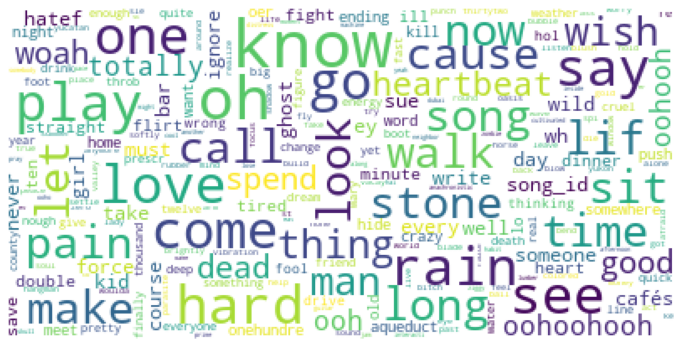

In [18]:
mpl.rcParams['figure.figsize']=(12.0,12.0)  
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 

wordcloud = WordCloud(
                          background_color='white',
                          max_words=500,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(songlyrics['cleaned_lyrics'].replace("'","")))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Do a set of -grams graphs. This will pull the most common indiviual words in the lyrics corpus, called unigrams, as well as common two word and three word phrases called bigrams and trigrams.

count vectorizer changes lists of words into vectors, but term frequency-inverse document frequency penalizes the word counts for words that appear very often. They should be less likely to provide insight into the specific topics of a document given how common the word is.

In [19]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(songlyrics['cleaned_lyrics'], 30)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

fig = go.Figure([go.Bar(x=df2['unigram'], y=df2['count'])])
fig.update_layout(title=go.layout.Title(text="Top 30 unigrams in the question text after removing stop words and lemmatization"))
fig.show()

In [20]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(songlyrics['cleaned_lyrics'], 30)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

fig = go.Figure([go.Bar(x=df3['bigram'], y=df3['count'])])
fig.update_layout(title=go.layout.Title(text="Top 20 bigrams in the question text after removing stop words and lemmatization"))
fig.show()

In [21]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(songlyrics['cleaned_lyrics'], 30)
df4 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

fig = go.Figure([go.Bar(x=df4['trigram'], y=df4['count'])])
fig.update_layout(title=go.layout.Title(text="Top 30 trigrams in the question text"))
fig.show()

Change the lyrics lists into vectors

In [24]:
vectorizer = CountVectorizer(analyzer='word',stop_words='english', min_df=25, max_df=.8, lowercase=True, token_pattern='[a-zA-Z0-9]{3,}')

bag_lyrics= vectorizer.fit_transform(songlyrics['cleaned_lyrics'])

In [26]:
LDA_model=LatentDirichletAllocation(n_components=3,learning_method='online',n_jobs= -1,random_state=0)

LDA_result = LDA_model.fit_transform(bag_lyrics)

pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(LDA_model,bag_lyrics,vectorizer)

C:\Users\16142\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.116840  0.138057       1        1  50.148004
0     -0.129254 -0.133491       2        1  38.019699
1      0.246095 -0.004566       3        1  11.832297, topic_info=     Category          Freq       Term         Total  loglift  logprob
1162  Default  11178.000000       like  11178.000000  30.0000  30.0000
2069  Default   5075.000000       tell   5075.000000  29.0000  29.0000
1110  Default  13520.000000       know  13520.000000  28.0000  28.0000
2338  Default   2807.000000       yeah   2807.000000  27.0000  27.0000
1205  Default   9419.000000       love   9419.000000  26.0000  26.0000
753   Default   6983.000000       feel   6983.000000  25.0000  25.0000
1176  Default   2630.000000       live   2630.000000  24.0000  24.0000
2248  Default   7794.000000       want   7794.000000  23.0000  23.0000
2114  Default   7671.000000       time   7671.000000  22.0000  22.0000
583   Default   2229.000000        die   2229.000000  21.0000  21.0000
2168  Default   3970.000000        try   3970.000000  20.0000  20.0000
1091  Default  10331.000000       just  10331.000000  19.0000  19.0000
977   Default   1078.000000        hey   1078.000000  18.0000  18.0000
839   Default   1075.000000       fuck   1075.000000  17.0000  17.0000
1041  Default    984.000000  important    984.000000  16.0000  16.0000
1700  Default   8648.000000        say   8648.000000  15.0000  15.0000
2090  Default   5496.000000      think   5496.000000  14.0000  14.0000
2247  Default   3368.000000      wanna   3368.000000  13.0000  13.0000
868   Default   1680.000000       girl   1680.000000  12.0000  12.0000
1232  Default   2413.000000        man   2413.000000  11.0000  11.0000
1536  Default    758.000000   probably    758.000000  10.0000  10.0000
1175  Default   2440.000000     little   2440.000000   9.0000   9.0000
79    Default   1354.000000        ask   1354.000000   8.0000   8.0000
38    Default   1000.000000    alright   1000.000000   7.0000   7.0000
1160  Default   3215.000000      light   3215.000000   6.0000   6.0000
101   Default   2534.000000       baby   2534.000000   5.0000   5.0000
1094  Default    652.000000        kid    652.000000   4.0000   4.0000
1279  Default   2645.000000       mind   2645.000000   3.0000   3.0000
516   Default    909.000000      dance    909.000000   2.0000   2.0000
1870  Default    621.000000   somebody    621.000000   1.0000   1.0000
...       ...           ...        ...           ...      ...      ...
240    Topic3    276.423242  breathing    294.689245   2.0703  -5.6970
1770   Topic3    516.021174       shit    588.630418   2.0027  -5.0727
2338   Topic3   2049.182477       yeah   2807.637828   1.8194  -3.6937
1558   Topic3    215.990019      queen    231.401767   2.0654  -5.9437
1650   Topic3    471.631669       rock    620.865824   1.8594  -5.1627
644    Topic3    432.808262       drop    573.762234   1.8524  -5.2486
1176   Topic3   1370.578392       live   2630.967229   1.4822  -4.0959
1162   Topic3   3774.635369       like  11178.494266   1.0486  -3.0828
583    Topic3   1121.236511        die   2229.544019   1.4470  -4.2967
38     Topic3    624.404314    alright   1000.042458   1.6633  -4.8821
1297   Topic3    530.267550     moment    836.757724   1.6782  -5.0455
2069   Topic3   1846.739539       tell   5075.956645   1.1232  -3.7977
516    Topic3    556.256562      dance    909.328495   1.6429  -4.9977
70     Topic3    288.888336     arrive    360.525018   1.9128  -5.6529
752    Topic3    344.529914       feed    495.892089   1.7702  -5.4767
1093   Topic3    307.100212       kick    411.867959   1.8408  -5.5917
79     Topic3    617.132833        ask   1354.350607   1.3483  -4.8938
753    Topic3   1391.251229       feel   6983.104020   0.5210  -4.0809
168    Topic3    374.490995       bird    604.415327   1.6556  -5.3933
2168   Topic3    879.739437        try   3970.858342   0.6272  -4.

In [27]:
def show_topics(vectorizer=vectorizer, lda_model=LDA_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in LDA_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=LDA_model, n_words=20)

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

#topic 1 Ego
#topic 2 Superego
#topic 3 Id

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19
Topic 0,come,light,like,eye,run,hand,home,leave,make,night,hear,dream,man,turn,let,face,watch,water,look,hold
Topic 1,like,yeah,tell,feel,live,die,hey,fuck,important,try,probably,man,kid,little,alright,ask,somebody,girl,make,dance
Topic 2,know,just,love,say,want,time,make,feel,think,come,like,way,let,ill,thing,away,wanna,day,need,cause


In [28]:
Topics_theme = ['Ego','Super Ego','Id']
df_topic_keywords['topic_theme'] = Topics_theme
df_topic_keywords.set_index('topic_theme', inplace=True)
df_topic_keywords.T

topic_theme,Ego,Super Ego,Id
Word 0,come,like,know
Word 1,light,yeah,just
Word 2,like,tell,love
Word 3,eye,feel,say
Word 4,run,live,want
Word 5,hand,die,time
Word 6,home,hey,make
Word 7,leave,fuck,feel
Word 8,make,important,think
Word 9,night,try,come


In [29]:
# get the topic fractions output from the LDA model
LDA_result = LDA_model.transform(bag_lyrics)

# get the names from the topics
topicnames = df_topic_keywords.T.columns

# index names
index = range(len(songlyrics))

# Make the pandas dataframe
topics= pd.DataFrame(np.round(LDA_result, 3)*100, columns=topicnames, index=index)

# Get dominant topic for each document
dominant_topic = np.argmax(topics.values, axis=1)
topics['dominant_topic'] = dominant_topic

topics.reset_index(inplace=True)
lyrics_topics= pd.merge(songlyrics, topics, left_index=True, right_index=True)

lyrics_topics.drop(['rating','rating_interpretation','index','cleaned_lyrics','cleaned_lyrics_word_length','playcount','dominant_topic'], axis=1,inplace=True)


In [30]:
lyrics_topics.to_csv('music_topics.csv')

In [31]:
lyrics_topics

,artist,album,title,lyrics,lyrics_word_length,artist_id,Ego,Super Ego,Id
song_id,,,,,,,,,
0,Bon Iver,22 A Million,00000 Million,Mustve been forces that took me on them wild c...,233,0,42.0,7.3,50.7
1,M83,Dead Cities Red Seas Lost Ghosts,0078h,I was someone elses girl Every time you look i...,179,1,0.7,0.8,98.4
2,The Magnetic Fields,50 Song Memoir,02 Be True to Your Bar,Sitting in bars and cafés Writing songs about ...,197,2,0.6,18.6,80.8
3,The Magnetic Fields,50 Song Memoir,05 Never Again,Well walk in the rain Just having a day Never ...,150,2,50.3,0.8,48.8
4,The Magnetic Fields,50 Song Memoir,06 Quotes,For some of which you could have sued Oh the h...,101,2,19.2,8.3,72.5
5,Swearin,Swearin,1,Ignore the ghosts you can let me out Im not th...,43,3,24.0,2.8,73.2
6,Remember Sports,Slow Buzz,The 1 Bad Man,But I’m not getting over it And I know and I k...,169,4,0.7,0.7,98.6
7,Jay Som,Everybody Works,1 Billion Dogs,Just like a kid Cant see straight Im tired and...,103,5,29.7,34.6,35.7
8,Tapes n Tapes,The Loon,10 Gallon Ascots,Ill come to dinner and fight off the flirts I ...,102,6,77.8,0.8,21.4


Now that we have an LDA model that  split each song into 4 topics, lets test how well it does with new songs.

In [32]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException

from webdriver_manager.chrome import ChromeDriverManager

import time
import string
import requests
from bs4 import BeautifulSoup

import unidecode
import pandas as pd

In [33]:
# set driver options and import song list
option = webdriver.ChromeOptions()
option.add_argument(' - incognito')

ooh la la by run the jewels - works. combine all into a function that takes a genius page url and outputs the topic breakdown

In [39]:
def lyric_grab(url):
    driver = webdriver.Chrome(ChromeDriverManager().install())
    driver.implicitly_wait(30)

    driver.get(url)

    page= driver.find_element_by_xpath(f'/html/body/routable-page/ng-outlet/song-page/div/div/div/div/div')

    soup=BeautifulSoup(page.text,'html.parser')
    driver.quit()

    s=str(soup)
    s=s.replace('\u2005',' ')
    s=s.split('\n')
    s.pop()
    s.pop()
    s.pop(0)

    s=[x for x in s if '[' not in x]
    for line in s:
        if line == '':
            s.remove('')

    lyrics=''
    for line in s:        
        lyrics+=str(line)
        lyrics+=' '
    return lyrics

def Freud(url):
    lyrics=lyric_grab(url)
    lyrics=clean_text(lyrics)
    lyrics=lemmatizer(lyrics).replace('-PRON-','')
    lyric_list=[]
    lyric_list.append(lyrics)
    vector=vectorizer.transform(lyric_list)
    prob_scores=LDA_model.transform(vector)
    print('         Ego          SuperEgo          id')
    return prob_scores[0]

In [40]:
url='https://genius.com/Be-your-own-pet-the-kelly-affair-lyrics'

Freud(url)

[WDM] - Cache is valid for [05/06/2020]
[WDM] - Looking for [chromedriver 83.0.4103.39 win32] driver in cache 
[WDM] - Driver found in cache [C:\Users\16142\.wdm\drivers\chromedriver\83.0.4103.39\win32\chromedriver.exe]


 
         Ego          SuperEgo          id


array([0.10568112, 0.4279531 , 0.46636578])

works try your own! export the models used to do this so it can be used anytime!

In [41]:
pickle.dump(LDA_model, open('Nathan_Freud_Music_Psychologist.sav','wb'))

In [42]:
pickle.dump(vectorizer, open('Nathan_Freud_vectorizer.sav','wb'))